# Apply Topic Modelling Analysis on COVID-19 Documents with NMF

This jupyter notebook demonstrates document clustering with NMF topic modelling and generating tags from the clustered documents.

**About NMF**

- NMF : Non-Negative Matrix Factorization (NMF) is an unsupervised technique. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative. Using the original matrix (X), NMF will give you two matrices (W and H). W is the topics it found and H is the coefficients (weights) for those topics. In other words, X is articles by words (original), H is articles by topics and W is topics by words.

**Extracting features**
- We use TFIDF vectorizer instead of Count vectorizer for extracting features. 

**Parameters**
- We have chosen a value of Minimum DF equal to 20 to get rid of extremely rare words that appear in less than 20 documents, and a Maximum DF equal to 80%. 


In [1]:
import pandas as pd
from os.path import exists
import numpy as np
import itertools
import matplotlib.pyplot as plt
import re
import json
import nltk
import ast
import pickle
import datetime as dt
import operator
import pathlib
import timeit
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import decomposition
from sklearn.decomposition import NMF
from gensim.models import Word2Vec
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

/Users/jihoonwoo/opt/anaconda3/envs/covid_venv/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
DATA_PATH = '../Data/preprocessed_data/'
MIN_DF =  20
MAX_DF = 0.8
NORM_FUNCTION = 'l1'
No_TOP_KEYOWRDS = 5
OUTPUT_PATH = '../data/outputs/'

## Load preprocessed data

In [3]:
df = pd.read_csv(DATA_PATH + "preprocessed_data.tsv", sep='\t', encoding='utf-8')

## Extract features 

In [4]:
def write_object(obj, output_fname):
    f = open(output_fname, 'wb')
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [5]:
def data_vectorization(weight, PATH, training_docs, _min_df, _max_df, norm_function):
    
    V_fname = PATH + "_V_{}.pkl".format(weight)
    D_fname = PATH + "_D_{}.pkl".format(weight)
    
    if exists(V_fname):
        V = pickle.load( open(V_fname, "rb") )
        D = pickle.load( open(D_fname, "rb") )
    else:
        if weight == 'tfidf':
            V = TfidfVectorizer(analyzer='word', min_df=_min_df, norm=norm_function, max_df=_max_df, encoding='utf-8') # Term Frequency times inverse document frequency.
            D = V.fit_transform(training_docs)
        else:
            V = CountVectorizer(analyzer='word', min_df=_min_df, max_df=_max_df, encoding='utf-8') 
            D = V.fit_transform(training_docs)

        # write the vectorizer and data
        write_object(V, V_fname)
        write_object(D, D_fname)

    return V, D

In [6]:
weight = "tfidf" # count or tfidf

corpus = list(df['text'])
V, D = data_vectorization(weight, DATA_PATH, corpus, MIN_DF, MAX_DF, NORM_FUNCTION)

## Find the optimal topic size by coherence means 

In [7]:
w2v_model = Word2Vec.load('../Data/covid_word2vec/covid_100d.model')

In [8]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if w2v_model.wv.__contains__(pair[0]) and w2v_model.wv.__contains__(pair[1]):
                similarity = w2v_model.wv.similarity(pair[0], pair[1])
                pair_scores.append(max(0, similarity)) # return positive value
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


In [9]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [10]:
def get_coherence(V, D, w2v_model, No_TOP_KEYOWRDS):

    kmin, kmax = 3, 30
    
    topic_models = []
    k_values = []
    coherences = []
    # try each value of k
    for k in range(kmin,kmax+1):
        # run NMF
        model = decomposition.NMF( init="nndsvd", n_components=k, random_state=1, max_iter=800) # 'nndsvd' works best for sparse data where the most of value are 0
        W = model.fit_transform( D ) # fit vectorization results
        H = model.components_    
        # store for later
        topic_models.append( (k,W,H) )
        # Get top-n topic descriptors 
        term_rankings = []
        for topic_index in range(k):
            term_rankings.append( get_descriptor( V.get_feature_names(), H, topic_index, No_TOP_KEYOWRDS ) )
        # Now calculate the coherence based on our Word2vec model
        k_values.append( k )
        coherences.append( calculate_coherence( w2v_model, term_rankings ) )
        print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
   
    return k_values, coherences

In [ ]:
No_TOP_KEYOWRDS = 5
k_values, coherences = get_coherence(V, D, w2v_model, No_TOP_KEYOWRDS)

In [12]:
coherence_df = pd.DataFrame()
coherence_df['k'] = k_values
coherence_df['coherences mean'] = coherences
coherence_df.to_csv("../Data/figures/coherence_mean.csv", index=False)

In [13]:
def show_coherence(k_values, coherences, No_TOP_KEYOWRDS):
    fig = plt.figure(figsize=(12,8))
    # create the line plot
    ax = plt.plot( k_values, coherences )
    #plt.title('Coherence Mean with {} top keywords'.format(No_TOP_KEYOWRDS))
    plt.title('Coherence Mean')
    plt.xticks(k_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Mean Coherence")
    plt.grid()
    # add the points
    plt.scatter( k_values, coherences, s=36)
    # find and annotate the maximum point on the plot
    """
    ymax = max(coherences)
    xpos = coherences.index(ymax)
    best_k = k_values[xpos]
    plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
    """
    plt.savefig('../img/coherence.jpeg', doi=400, bbox_inches='tight') 
    # show the plot
    plt.show()

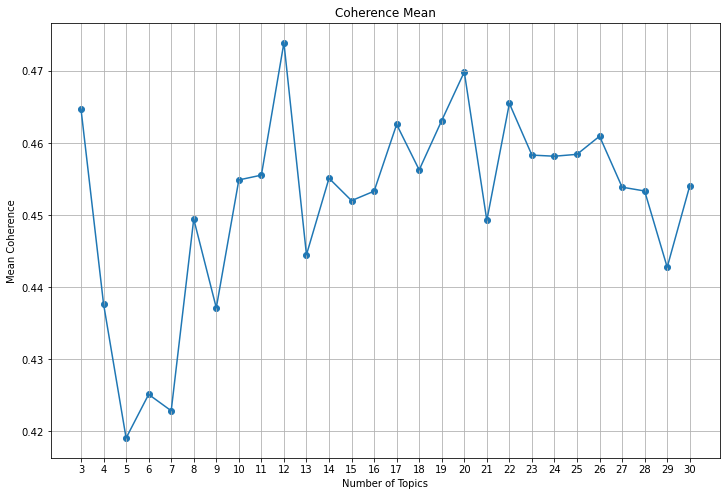

In [14]:
show_coherence(k_values, coherences, No_TOP_KEYOWRDS) 

## Apply topic modelling

In [7]:
k = 12
NMF_model = NMF(n_components=k, init='nndsvd', random_state=1).fit(D)
H = NMF_model.transform(D) # articles by topic
W = NMF_model.components_  # topics by words.

In [9]:
# identify first and second topic for each article

top2_clusters_df = pd.DataFrame()
top2_clusters_df['_id'] = df['_id']

top_1_cluster_list=[]
top_2_cluster_list=[]
top_1_cluster_weight_list=[]
top_2_cluster_weight_list=[]

for a in H:
    top_2_idx = np.argsort(a)[-2:]
    top_2_values = [a[i] for i in top_2_idx]
    top_1_cluster_list.append(str(top_2_idx[1]))
    top_2_cluster_list.append(str(top_2_idx[0]))
    top_1_cluster_weight_list.append(round(top_2_values[1], 5))
    top_2_cluster_weight_list.append(round(top_2_values[0], 5))
    
top2_clusters_df['top1_cluster'] = top_1_cluster_list
top2_clusters_df['top2_cluster'] = top_2_cluster_list
top2_clusters_df['top1_cluster_weight'] = top_1_cluster_weight_list
top2_clusters_df['top2_cluster_weight'] = top_2_cluster_weight_list

# Explore topic modelling results

## Print clusters keywords 

In [10]:
def get_top_keywords(model, optimal_topic_size, n_top_words, V):
    
    feat_names = V.get_feature_names()
    
    word_dict = {};
    for i in range(optimal_topic_size):
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Cluster # ' + '{:02d}'.format(i)] = words;
    
    return pd.DataFrame(word_dict);

In [11]:
No_TOP_KEYOWRDS = 5
pd.set_option('display.max_columns', None)
# print top-n keywords for the topics
nmf_df = get_top_keywords(NMF_model, k, No_TOP_KEYOWRDS, V)
nmf_df.to_csv(OUTPUT_PATH+"{}Keywords_in_{}_clusters.csv".format(No_TOP_KEYOWRDS, k), sep=',', encoding='utf-8', index=False)
nmf_df

,Cluster # 00,Cluster # 01,Cluster # 02,Cluster # 03,Cluster # 04,Cluster # 05,Cluster # 06,Cluster # 07,Cluster # 08,Cluster # 09,Cluster # 10,Cluster # 11
0,pandemic,patient,vaccine,impact,infection,disease,health,review,student,child,cancer,structure
1,surgery,clinical,vaccination,lockdown,syndrome,cardiovascular,mental,systematic,learning,adolescent,care,complex
2,management,outcome,mrna,economy,acute,novel,care,meta_analysis,study,parent,treatment,crystal
3,lesson,mortality,hesitancy,economic,respiratory,severity,worker,literature,education,multisystem,breast,protease
4,challenge,hospitalized,variant,psychological,severe,management,public,treatment,time,inflammatory,lung,spike


In [12]:
def get_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    
    feat_names = V.get_feature_names()
    
    word_dict = {};
    for i in range(optimal_topic_size):
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Cluster # ' + '{:02d}'.format(i)] = words;
    
    return pd.DataFrame(word_dict);

In [13]:
def get_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    feature_names = V.get_feature_names()
    keywords_df = pd.DataFrame()
    k = 0
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        keywords_df["Cluster #{} keywords".format(k)] = top_features
        keywords_df["Cluster #{} keywords weights".format(k)] = weights
        k +=1
    return keywords_df

In [14]:
keywords_df = get_top_keyword_weights(NMF_model, k, 100, V)
keywords_df.to_csv(OUTPUT_PATH+"{}Keywords_in_{}_clusters_with_weights.csv".format(100, k), sep=',', encoding='utf-8', index=False)

In [15]:
def print_top_keyword_weights(model, optimal_topic_size, n_top_words, V):
    feature_names = V.get_feature_names()
    fig, axes = plt.subplots(3, 4, figsize=(24, 15), sharex=True)
    axes = axes.flatten()
   
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
    
        for p in ax.patches:
            if topic_idx == 0:
                ax.annotate(str(round(p.get_width(),2)), (6.5, p.get_y() + p.get_height()),size=16)
            else:
                ax.annotate(str(round(p.get_width(),2)), (5.5, p.get_y() + p.get_height()),size=16)
            #ax.annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height()/8),fontsize=12)
            #print(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height()))
    
        ax.set_title(f"Cluster# {topic_idx}", fontdict={"fontsize": 20})
        
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        #fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

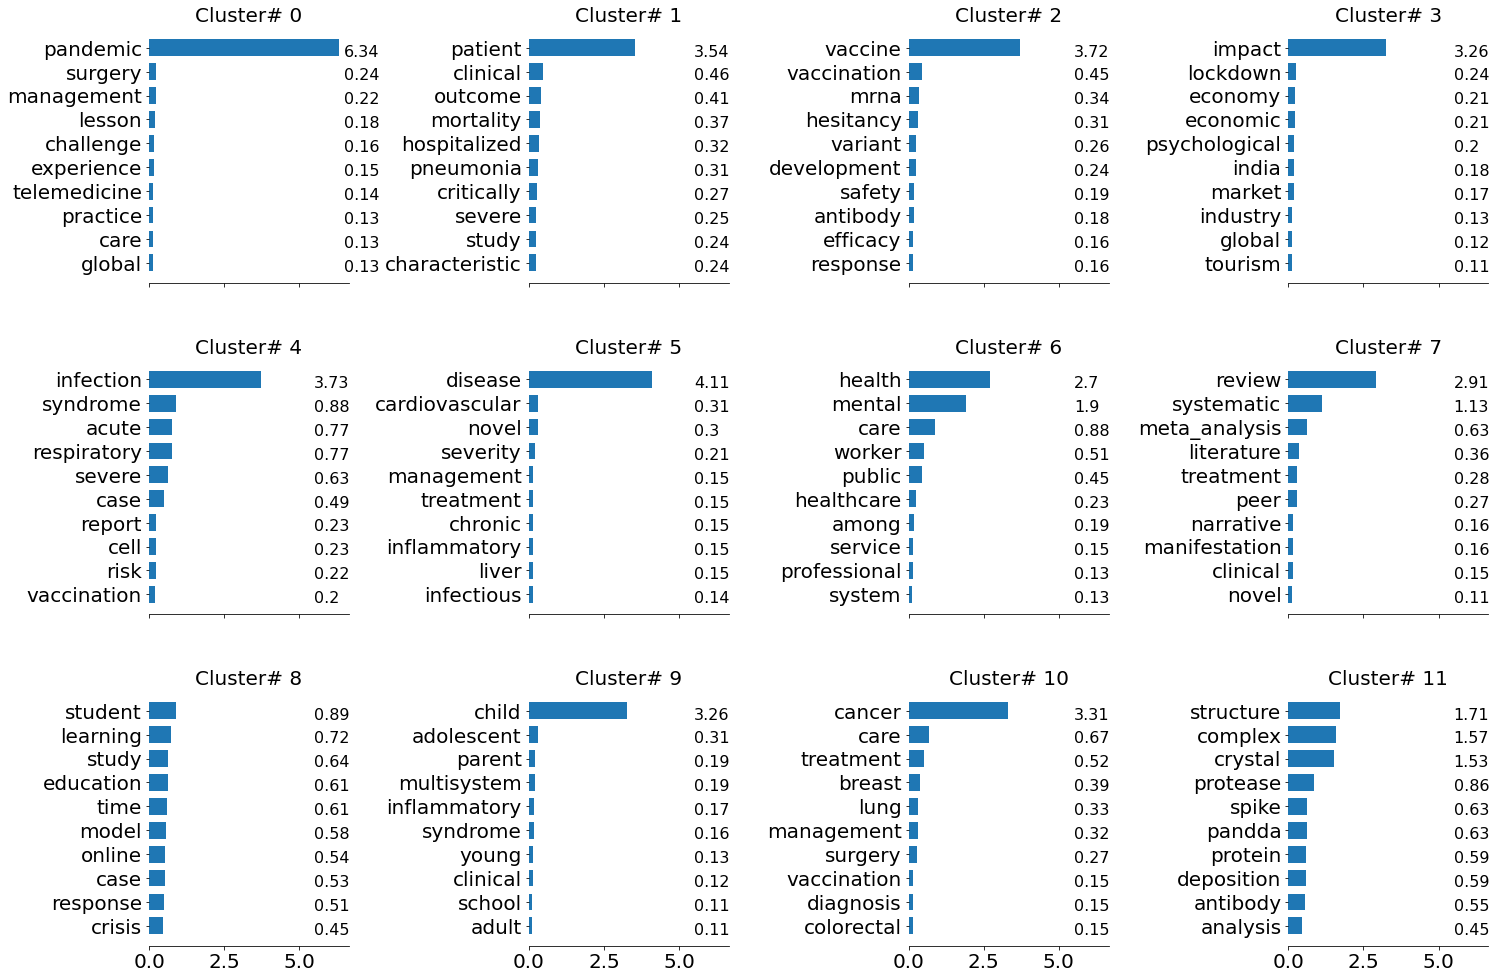

In [16]:
print_top_keyword_weights(NMF_model, k, 10, V)

## Print number of articles in the clusters

In [17]:
# count articles in clusters

top1_cluster_counter = {}

for index, row in top2_clusters_df.iterrows():
    col1 = row['top1_cluster']
    col2 = row['top2_cluster']
    if '# ' + '{:02d}'.format(int(col1)) not in top1_cluster_counter.keys():
        top1_cluster_counter['# ' + '{:02d}'.format(int(col1))] = 1
    else:
        top1_cluster_counter['# ' + '{:02d}'.format(int(col1))] += 1


In [18]:
# sort dictionary by key (cluster number)
top1_num_of_articles = []

for key in sorted(top1_cluster_counter):
    top1_num_of_articles.append(top1_cluster_counter[key])

In [19]:
def show_distribution(unique, top1_num_of_articles):
    plt.figure(figsize=(12, 6))

    plt.bar(unique, top1_num_of_articles)
    plt.yticks(fontsize=14)
    plt.xticks(unique, unique)
    plt.ylabel('Number of research articles', fontweight='bold', fontsize=14)
    plt.xlabel('Clusters', fontweight='bold', fontsize=14)
    
    for index, value in enumerate(top1_num_of_articles):
        plt.text(index-0.4, top1_num_of_articles[index]+1000, f"{top1_num_of_articles[index]:,}", fontsize=12)
    plt.legend()
    #plt.grid(True, axis='y')
    plt.savefig('../img/topic-distribution.jpeg', doi=2000, bbox_inches='tight')  
    plt.show()

No handles with labels found to put in legend.


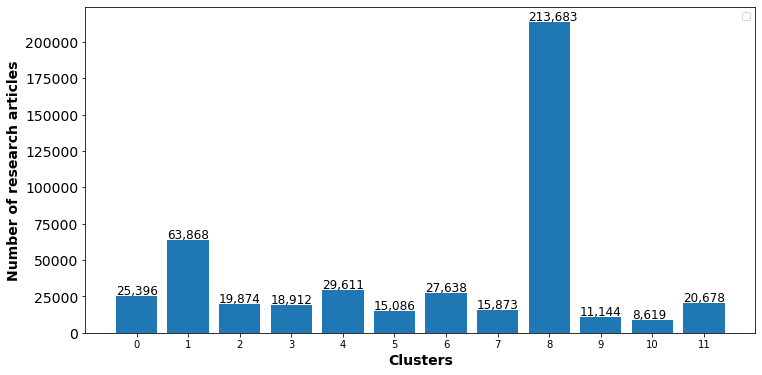

In [20]:
# show number of articles

unique = range(k)
show_distribution(unique, top1_num_of_articles)

## Article co-occurrence 

In [21]:
# Identify Sum of x and number of x

c_pair_x_num = {} # coumt number of x
c_pair_x_sum = {} # sum of x
for index, row in top2_clusters_df.iterrows():
    c_pair = (row['top1_cluster'], row['top2_cluster'])
    if c_pair not in c_pair_x_num.keys():
        c_pair_x_num[c_pair] = 1
    else:
        c_pair_x_num[c_pair] += 1

In [22]:

co_oc_df = pd.DataFrame(columns=['Cluster1', 'Cluster2', '# articles'])
for i in range(k):
    for j in range(k):
        if i == j:continue
        co_oc_df = co_oc_df.append({
            "Cluster1":str(i),
            "Cluster2":str(j),
            "# articles":str(c_pair_x_num[(str(i), str(j))] + c_pair_x_num[(str(j), str(i))])}, ignore_index=True)


In [24]:
# convert DF to matrix format

matrix_df = pd.DataFrame()
for c1 in range(k):
    placeholders = []
    for c2 in range(k):
        placeholders.append(0)
    matrix_df[c1] = placeholders
    
for index, row in co_oc_df.iterrows():
    cluster1 = int(str(row['Cluster1']).replace('.0', ''))
    cluster2 = int(str(row['Cluster2']).replace('.0', ''))
    
    cooccurrence = row['# articles']
    num_articles_in_first_collection = len(top2_clusters_df.loc[top2_clusters_df['top1_cluster'] == str(cluster1)])
    num_articles_in_second_collection = len(top2_clusters_df.loc[top2_clusters_df['top1_cluster'] == str(cluster2)])
    co_rate = round(int(cooccurrence)/(num_articles_in_first_collection + num_articles_in_second_collection), 3)
    matrix_df[cluster2].iloc[cluster1] = co_rate

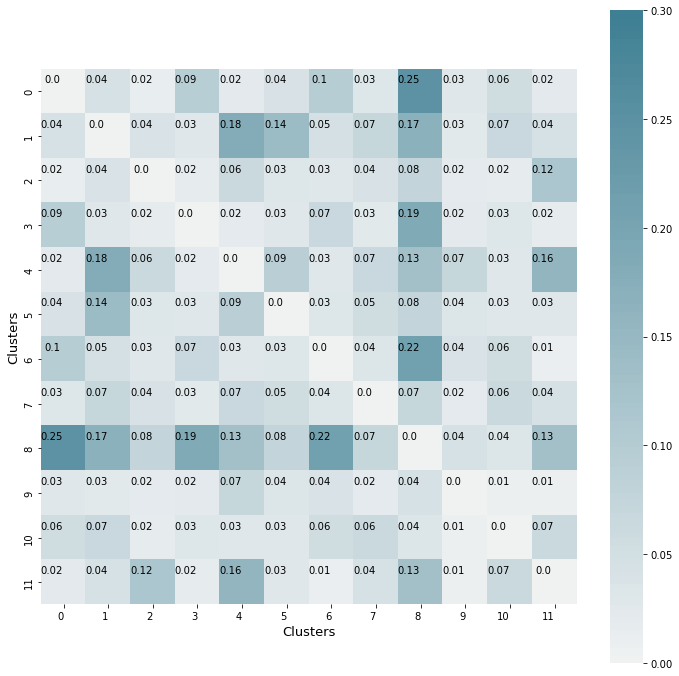

In [25]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,12))         
ax = sns.heatmap(
    matrix_df, 
    vmin=0, vmax=0.3, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    horizontalalignment='right'
);
j = 12
for c in matrix_df.columns:
    i = 0
    for index, row in matrix_df.iterrows():
        value = row[c]
        ax.text(i/12+0.02, j/12-0.02, round(value, 2), horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes)
        i += 1
    j -= 1
plt.xlabel('Clusters', fontsize = 13) 
plt.ylabel('Clusters', fontsize = 13) 

plt.savefig('../img/co-occurrence.jpeg', dpi=400, bbox_inches='tight')

In [37]:
matrix_df.to_csv("../Data/figures/cooccurrence_matrix.csv", index=False)

## Topc weights

### Average topic weights

In [27]:
topic_w_list = []
for c in range(k):
    sub_df1 = top2_clusters_df['top1_cluster_weight'].loc[top2_clusters_df['top1_cluster'] == '{}'.format(c)]
    total_weight = 0
    for a in sub_df1:
        total_weight += a
    topic_w_list.append(round(total_weight/len(sub_df1), 4))

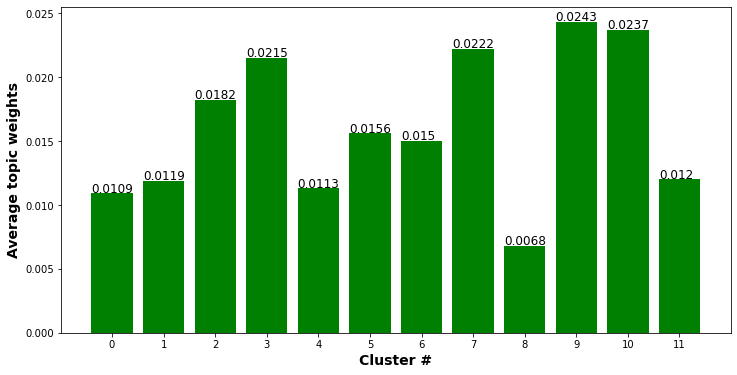

In [28]:
plt.figure(figsize=(12, 6))
plt.bar(unique, topic_w_list, color='green')
#plt.yticks(fontsize=14)
plt.xticks(unique, unique)
plt.ylabel('Average topic weights', fontweight='bold', fontsize=14)
plt.xlabel('Cluster #', fontweight='bold', fontsize=14)
for index, value in enumerate(topic_w_list):
    plt.text(index-0.4, topic_w_list[index]+0.0001, topic_w_list[index], fontsize=12)
    
plt.show()

### Weight histogram

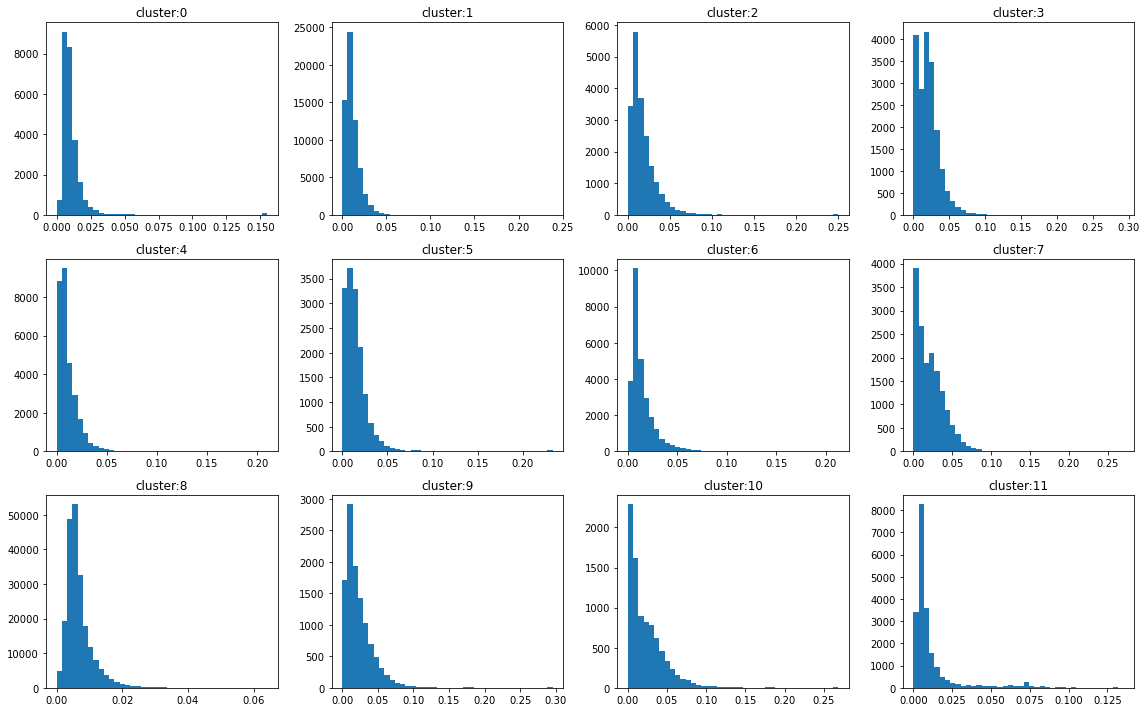

In [30]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

ncols = 4
nrows = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10))
c = 0
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i][j]
        weight_list = top2_clusters_df['top1_cluster_weight'].loc[top2_clusters_df['top1_cluster'] == '{}'.format(c)]
        weight_list= weight_list.sort_values(ascending=False)
        ax.hist(weight_list, bins=40)
        ax.set_title('cluster:{}'.format(c))
        c += 1

## Trend of articles per cluster

In [32]:
# merge the result to preprocessed data

covid_df = pd.read_csv(DATA_PATH + "merged_covid_articles.tsv", sep='\t', encoding='utf-8') 
merged_df = pd.merge(top2_clusters_df[['_id', 'top1_cluster']], covid_df, on='_id')
df = pd.merge(merged_df, df, on='_id')

In [33]:
def cleaning_text(date):
    row_value = ast.literal_eval(date)
    year = row_value['date-parts'][0][0]
    month = row_value['date-parts'][0][1]
    day = 1
    return "{}/{}/{}".format(month, day, year)

In [34]:
text_cleaning = lambda x: cleaning_text(x)
df['date'] = df['created'].apply(text_cleaning)
df['date'] = pd.to_datetime(df['date']).dt.to_period('M')
sorted_df = df.sort_values(by=['date'], inplace=False) # sort by date

In [35]:
# Only use top1 cluster

sub_df = sorted_df[['_id', 'top1_cluster', 'date']]
sub_df['top1_cluster'] = sub_df['top1_cluster'].apply(lambda x:'Cluster#' + '{:02d}'.format(int(x)))

In [36]:
groupby_sub_df = sub_df.groupby(['date', 'top1_cluster'])["_id"].count().reset_index(name="count")

In [37]:
# convert pivot table, thus each topic become column where value indicate number of document
table = pd.pivot_table(groupby_sub_df, values='count', index=['date'],
                    columns=['top1_cluster'], aggfunc=np.sum, fill_value=0)

table = table.reindex(sorted(table.columns), axis=1)

In [38]:
# convert table where values are cumulative
cum_table = table.cumsum(axis=0)

In [39]:
rank_cum_table = pd.DataFrame(columns=list(cum_table.columns))
i = 0
for index, row in cum_table.iterrows():
    l = cum_table.iloc[i]
    result = [sorted(l, reverse=True).index(x)+1 for x in l]
    rank_cum_table.loc[i] = result
    i += 1
    
rank_cum_table.index= cum_table.index

In [40]:
def bumpchart(df, selected_collections, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    fig = plt.figure(figsize=(9,5))
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    flag = 0
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)
            
        if col not in selected_collections:
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color='grey', alpha=0.1)
            
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color='green', alpha=0.1)
                
                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
        else: # highlight selected values
            if flag != 1: c = 'red'
            else: c='blue'
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color=c, label=col)
            left_yaxis.legend(loc='upper right')
            left_yaxis.set_xlabel("Date")
            left_yaxis.set_ylabel("Rank")
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color=c)

                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
            flag = 1
    # Number of lines
    lines = len(df.columns)
    y_ticks = [*range(0, lines)]
    
    x_ticks = []
    for j in range(1, len(df.index)+1, 12):
        x_ticks.append(rank_cum_table.index[j])
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    axis.xaxis.set_major_locator(plt.MaxNLocator(12))
    
    return axes

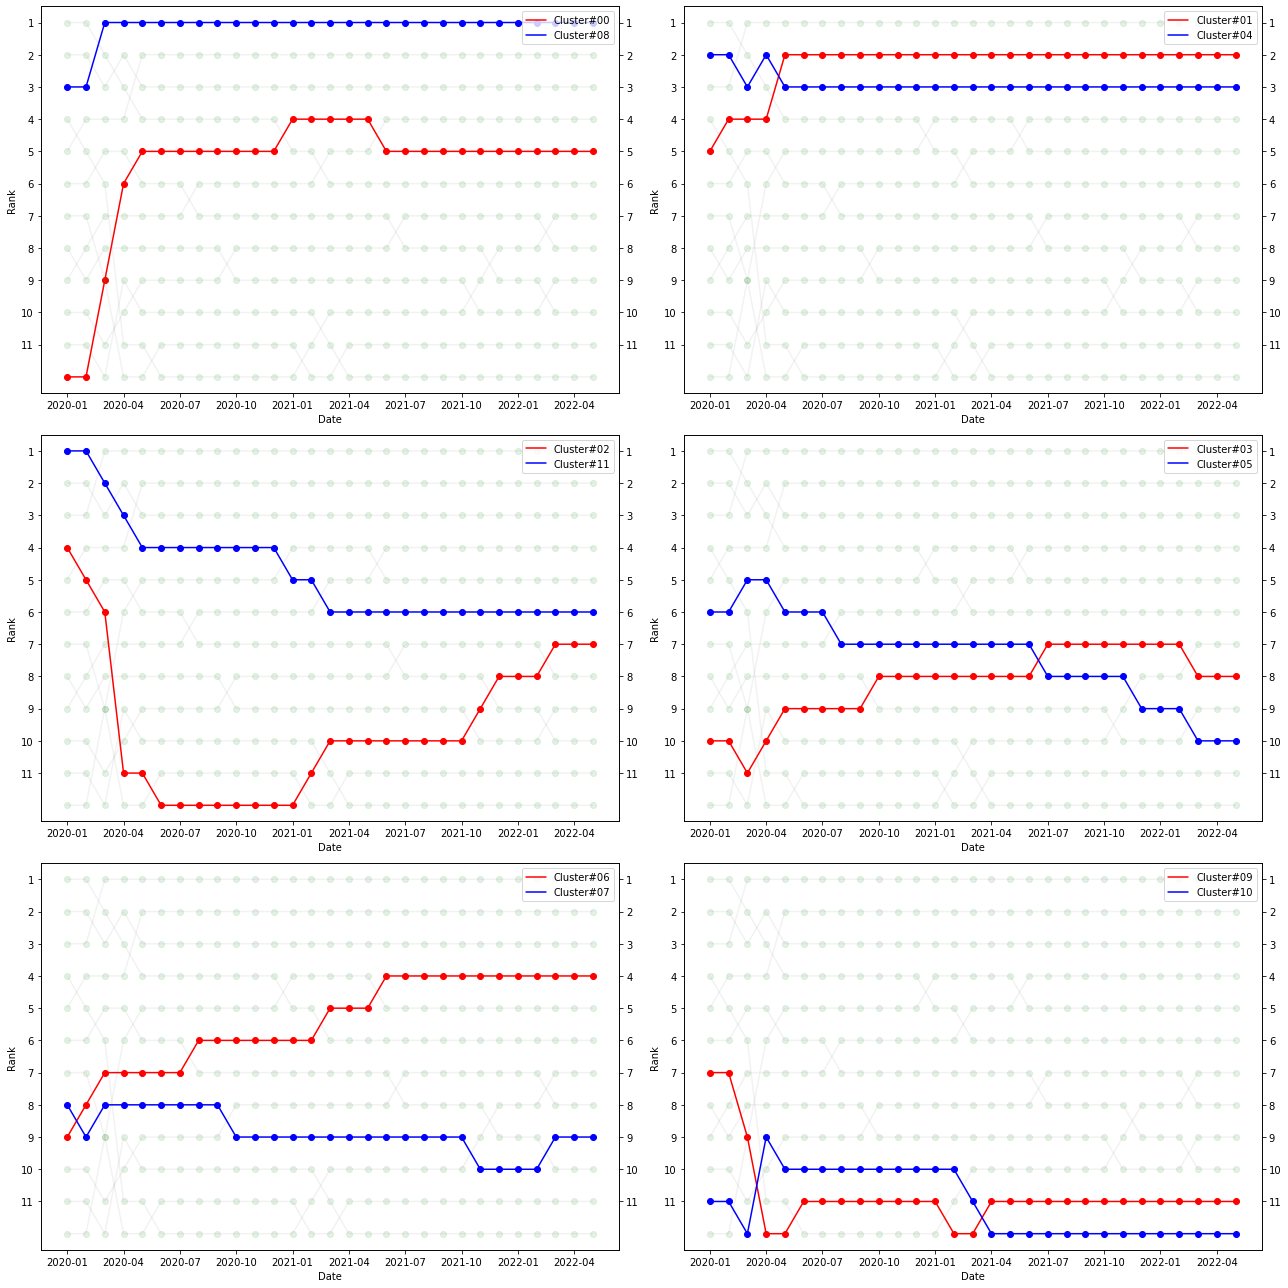

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

<Figure size 648x360 with 0 Axes>

In [41]:
fig, axs = plt.subplots(3,2, figsize=(18,18))

last_month = 29
rank_cum_table.index = rank_cum_table.index.astype(str)

bumpchart(rank_cum_table.tail(last_month), ['Cluster#00', 'Cluster#08'], show_rank_axis= False, scatter=True, ax=axs[0][0])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#01', 'Cluster#04'], show_rank_axis= False, scatter=True, ax=axs[0][1])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#02', 'Cluster#11'], show_rank_axis= False, scatter=True, ax=axs[1][0])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#03', 'Cluster#05'], show_rank_axis= False, scatter=True, ax=axs[1][1])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#06', 'Cluster#07'], show_rank_axis= False, scatter=True, ax=axs[2][0])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#09', 'Cluster#10'], show_rank_axis= False, scatter=True, ax=axs[2][1])

fig.savefig("../img/cluster_rank.jpeg", dpi=200)

In [52]:
rank_cum_table.to_csv("../Data/figures/article_trend.csv", index=False)

In [53]:
topic_name = {}
topic_name[0] = 'Pandemic impact'
topic_name[1] = 'Comorbidity'
topic_name[2] = 'Vaccine'
topic_name[3] = 'Socio-economic impact'
topic_name[4] = 'Infection'
topic_name[5] = 'Public health'
topic_name[6] = 'Health care management'
topic_name[7] = 'Literature and meta analysis'
topic_name[8] = 'Lifestyle and education impact'
topic_name[9] = 'Children and adolescent'
topic_name[10] = 'Cancer treatment'
topic_name[11] = 'Biochemistry'

In [54]:
max_topic_num_list = []
max_topic_name_list = []
topic_weights_list = []
for weights in H:
    top_idx = np.argsort(weights)[-1:]
    max_topic_num = top_idx[0] # max topic number
    max_topic_num_list.append(max_topic_num)
    max_topic_name_list.append(topic_name[max_topic_num]) # max topic number's name
    weight_dictionary = {}
    for i in range(len(weights)):
        weight_dictionary[topic_name[i]] = round(weights[i], 5)
    topic_weights_list.append(weight_dictionary) # save topic weights

In [55]:
# create new columns and save the results
df['research_topic_num'] = max_topic_num_list
df['research_topic'] = max_topic_name_list
df['topic_correlation'] = topic_weights_list

## Wordcloud

We create wordcloud for each cluster based on word frequency of top 1 cluster articles (Exclude articles matched with top2 clusters). 

In [56]:
import random 

def getRandomCol():
    r = random.randrange(30, 180)
    g = random.randrange(30, 180)
    b = random.randrange(30, 180)
    return (r, g, b)

def show_wordcloud(df):
    #topics = list(set(df['research_topic']))
    i = 0
    fig = plt.figure(figsize=(14,6))
    for t in range(k):
        ax = fig.add_subplot(3,4,i+1)
        topic_df = df.loc[df['research_topic_num'] == t]
        text = ''
        for index, row in topic_df.iterrows():
            text += row['text']
        wordcloud = WordCloud(background_color="white", collocations=False).generate(str(text))
        plt.title("Cluster {}".format(t))
        colour = getRandomCol()
        ax.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs: colour))
        ax.axis('off')
        i += 1
    plt.tight_layout()
    plt.savefig('../img/wordcloud.jpeg', doi=300, bbox_inches='tight')
    plt.show()

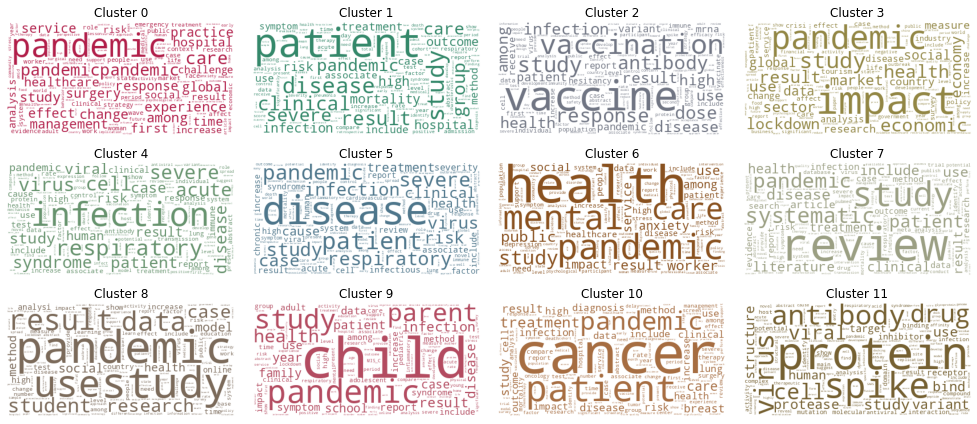

In [57]:
show_wordcloud(df)

In [ ]:
word_freq_df = pd.DataFrame()

for t in range(k):
    topic_df = df.loc[df['research_topic_num'] == t]
    word_freq_df['cluster_{}_words'.format(t)] = topic_df.text.str.split(expand=True).stack().value_counts().keys()[:100]
    word_freq_df['cluster_{}_words_frequency'.format(t)] = topic_df.text.str.split(expand=True).stack().value_counts().values[:100]
    word_freq_df.to_csv("../Data/figures/word_frequency_for_wordcloud(top100).csv", index=False)

## MetaData

In [42]:
covid_df = pd.read_csv(DATA_PATH + "merged_covid_articles.tsv", sep='\t', encoding='utf-8')
df = pd.merge(top2_clusters_df[['_id', 'top1_cluster']], covid_df, on='_id')

In [18]:
def count_publisher(df):
    missing_article = df['publisher'].isnull().sum()
    percent = round(missing_article/len(df)*100, 1)
    print("Missing publisher: {} ({}%)".format(missing_article, percent))
    publisher_df = df.groupby('publisher')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
    publisher_df.columns = ['publisher','Number of publications']
    return publisher_df

In [19]:
def count_subjects(df):
    missing_article = df['subject'].isnull().sum()
    print("Missing subject: {} ({}%)".format(missing_article, round(missing_article/len(df)*100, 1)))
    subjects_dict = {}
    for index, row in df.iterrows():
        if len(str(row['subject'])) > 3:
            subjects = eval(row['subject'])
            for s in subjects:
                if s in subjects_dict.keys():
                    subjects_dict[s] += 1
                else:
                    subjects_dict[s] = 1

    sorted_sub_dict = dict( sorted(subjects_dict.items(), key=operator.itemgetter(1),reverse=True))
    subject_df = pd.DataFrame()
    subject_df['Subjects'] = sorted_sub_dict.keys()
    subject_df['Number of publications'] = sorted_sub_dict.values()
    return subject_df

In [20]:
def count_container(df):
    df['container-title'] = df['container-title'].astype(str)
    missing_article = len(df.loc[df['container-title'] == 'nan'])
    print("Missing container: {} ({}%)".format(missing_article, round(missing_article/len(df)*100, 1)))
    df = df.loc[df['container-title'] != 'nan']
    container_df = df.groupby('container-title')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
    container_df.columns = ['container_title','Number of publications']
    container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("['", ''))
    container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("']", ''))
    return container_df

In [21]:
def count_funder(df):
    df['funder'] = df['funder'].astype(str)
    missing_article = len(df.loc[df['funder'] == 'nan'])
    print("Missing funder: {} ({}%)".format(missing_article, round(missing_article/len(df)*100, 1)))
    df = df.loc[df['funder'] != 'nan']
    funder_dict = {}
    for index, row in df.iterrows():
        if len(str(row['funder'])) > 3:
            funders = eval(row['funder'])
            for f in funders:
                try:
                    funder = f['name']
                    if funder in funder_dict.keys():
                        funder_dict[funder] += 1
                    else:
                        funder_dict[funder] = 1
                except:
                    continue

    sorted_funder_dict = dict( sorted(funder_dict.items(), key=operator.itemgetter(1),reverse=True))
    funder_df = pd.DataFrame()
    funder_df['Funders'] = sorted_funder_dict.keys()
    funder_df['Number of publications'] = sorted_funder_dict.values()
    return funder_df

In [22]:
def draw_subplots(top_n, df1, df2, df3, df4):
    fig, axs = plt.subplots(4,1,figsize=(12,24))
    
    x = list(df1['publisher'].iloc[:top_n])
    y = list(df1['Number of publications'].iloc[:top_n])     
    axs[0].barh(x, y, color='#728FCE')
    # top shows biggest value
    axs[0].invert_yaxis() 
    # for showing values on bar
    for p in axs[0].patches:
        axs[0].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[0].title.set_text("Top publishers")
    
    
    x = list(df2['Subjects'].iloc[:top_n])
    y = list(df2['Number of publications'].iloc[:top_n])     
    axs[1].barh(x, y, color='#7BCCB5')
    # top shows biggest value
    axs[1].invert_yaxis() 
    # for showing values on bar
    for p in axs[1].patches:
        axs[1].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[1].title.set_text("Top subjects")
    
    x = list(df3['container_title'].iloc[:top_n])
    y = list(df3['Number of publications'].iloc[:top_n])     
    axs[2].barh(x, y, color='#FFE87C')
    # top shows biggest value
    axs[2].invert_yaxis() 
    # for showing values on bar
    for p in axs[2].patches:
        axs[2].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[2].title.set_text("Top journals/conferences")
    
    x = list(df4['Funders'].iloc[:top_n])
    y = list(df4['Number of publications'].iloc[:top_n])     
    axs[3].barh(x, y)
    # top shows biggest value
    axs[3].invert_yaxis() 
    # for showing values on bar
    for p in axs[3].patches:
        axs[3].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=12)
    axs[3].title.set_text("Top funders")
    
    #plt.savefig('../img/top-{}-articles-metadata.jpeg'.format(top_n), doi='400', bbox_inches='tight')     
    

----------- CLUSTER 0 --------
Number of articles: 470382
Missing publisher: 213 (0.0%)
Missing subject: 185817 (39.5%)
Missing container: 65851 (14.0%)
Missing funder: 412456 (87.7%)


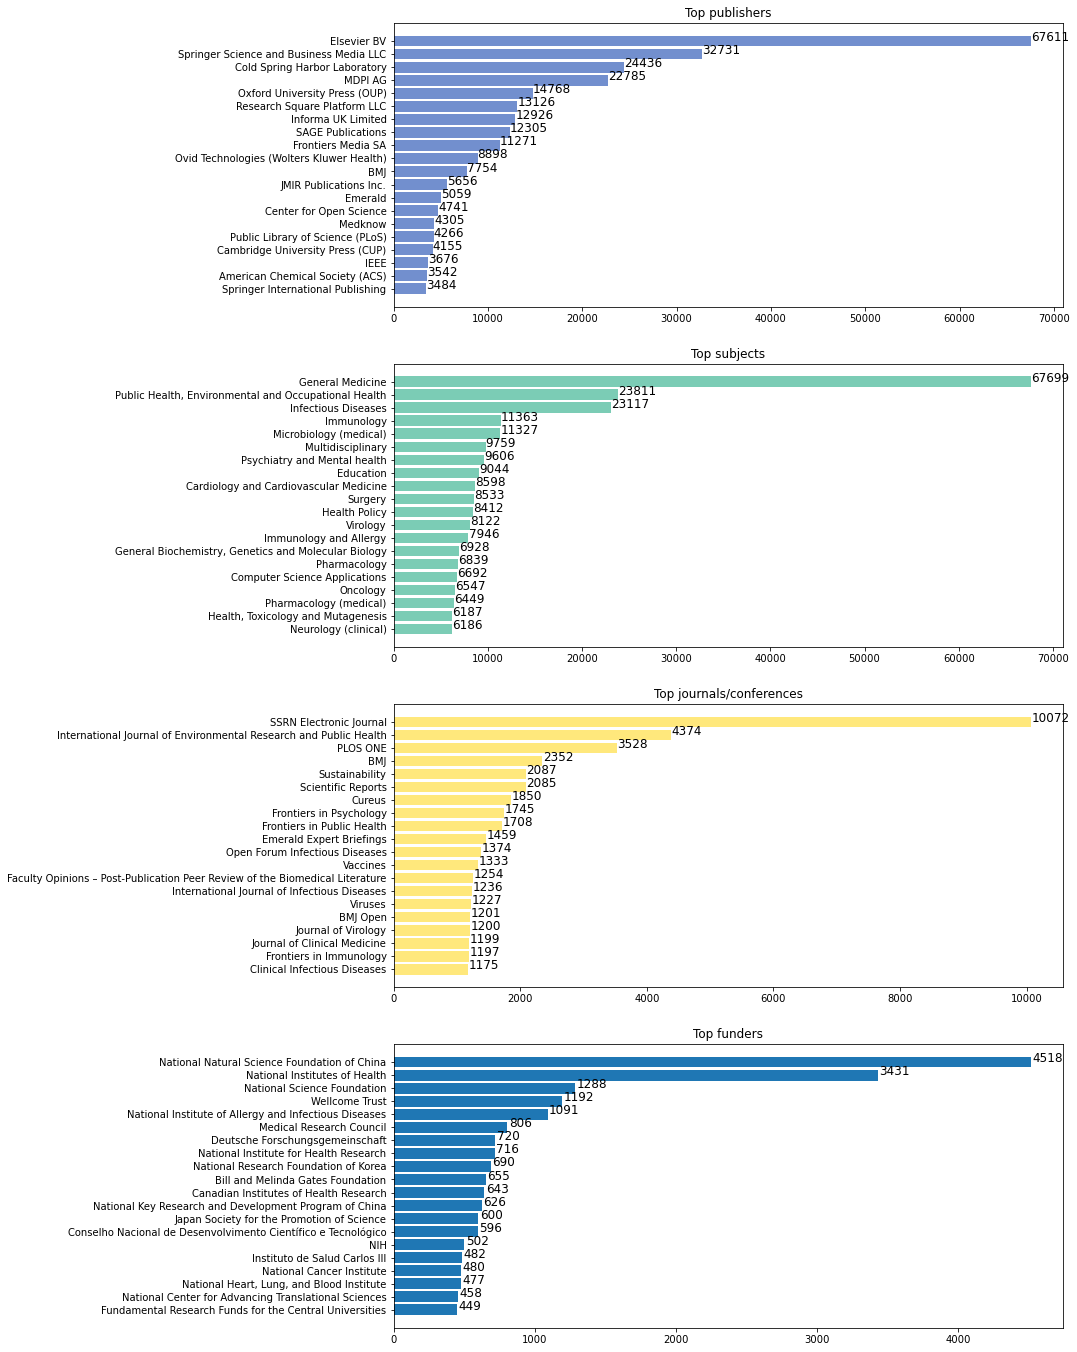

In [23]:
# Show metadata for entire articles
top_n = 20
k = 0
sub_df = df.loc[df['top1_cluster'] == str(k)]
print("----------- CLUSTER {} --------".format(k))
print("Number of articles: {}".format(len(df)))
draw_subplots(top_n, count_publisher(df), count_subjects(df), count_container(df), count_funder(df))

----------- CLUSTER 11 --------
Number of articles: 20678
Missing publisher: 1 (0.0%)
Missing subject: 8996 (43.5%)
Missing container: 6967 (33.7%)
Missing funder: 16413 (79.4%)


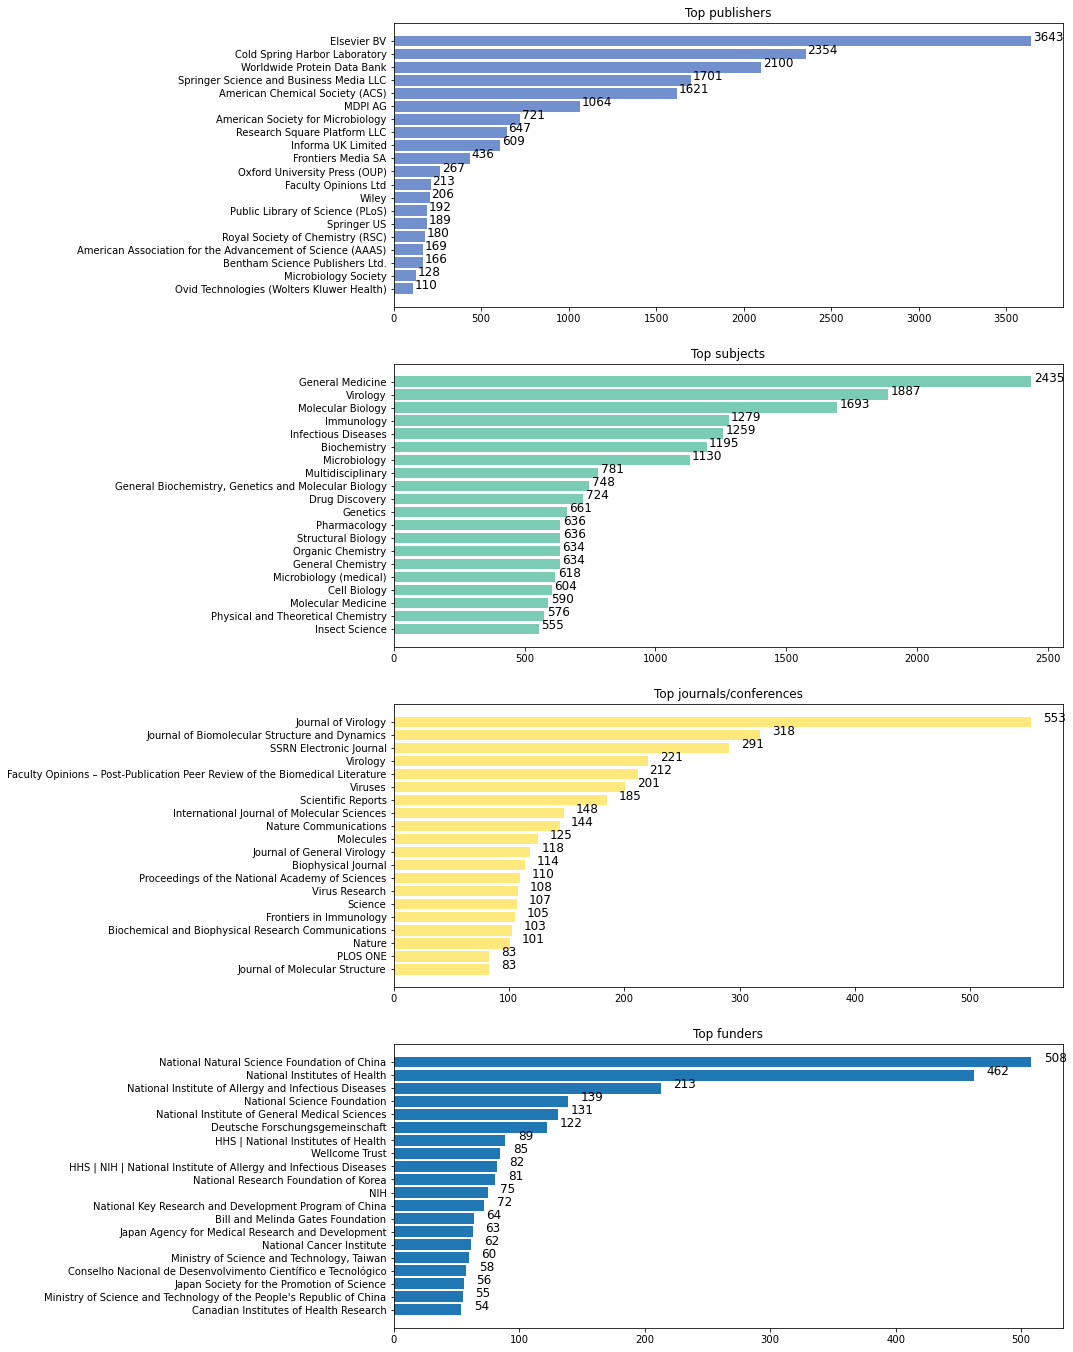

In [24]:
# Show metadata for selected cluster articles

top_n = 20
k = 11 # enter cluster number
sub_df = df.loc[df['top1_cluster'] == str(k)]
print("----------- CLUSTER {} --------".format(k))
print("Number of articles: {}".format(len(sub_df)))
draw_subplots(top_n, count_publisher(sub_df), count_subjects(sub_df), count_container(sub_df), count_funder(sub_df))